# DATASETS & DATALOADERS

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled fom model training code for better readability and modularity py torch provides tow data primitive: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. `Dataset` stores the samples of their corresponding labels and `DataLoader` wraps an iterable around the dataset to enable easy access tot the samples.

PyTorch domain libraries (TorchVsion, TorchAudio, TorchText) provide a number of pre-loaded datasets that subclass torch.utils.data.Dataset and implement functions specific for the particular data. They can be used to prototype and benchmark your model.

## Loading a dataset

Loading a sample dataset (FashionMNIST). 

In [1]:
# same as in quickstart
# importing torch

import torch # importing main torch library
from torch import nn # importing torch neural network related submodule
from torch.utils.data import DataLoader # importing DataLoader class
from torchvision import datasets # importing datasets class from vision-specific library torchvision
# other domain specific libraries are torchtext and torchaudio
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Downloading MNIST datasets
training_data = datasets.FashionMNIST(
    root =  "data",
    train = True,
    download = True,
    transform = ToTensor(),
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

# Iterating and Visualizing the dataset

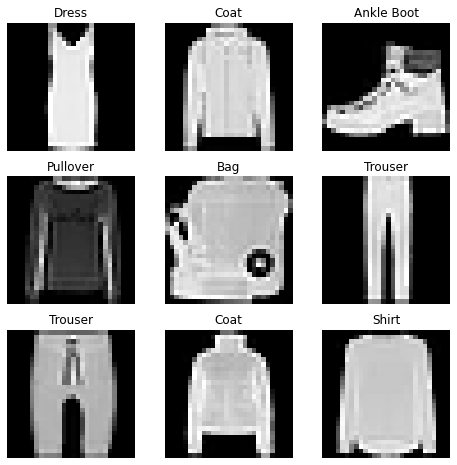

In [2]:
labels_map = {
     0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Creating custom dataset for your files

A custom `Dataset` class must implement three functions:

- `__init__`
- `__len__`
- `__getitem__`


Next is my implementation of the custom dataset. Images are stored in directory named `custom_dataset`, and the labels of the images are stored in file called `annotations_file.csv`. Version on PyTorch site lacks import of `Dataset` class.





In [3]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotation_file, names=["file_name", "label"])
        self.im_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.im_dir, self.img_labels.iloc[idx, 0])
        print(img_path)
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

        

## `__init__`

the `__init__` function is run once when instantiating `Dataset` object. We initialize the directory containing the images, the annotations file, and both transforms (more details in next notebook).

For the sake of this tutorial I created dummy dataset containging two pictures `dog.jpg` and `cat.jpg`. So the content of `labels.csv` file is:

```csv
dog.jpg, 0
cat.jpg, 1
```



## `__len__`

The function returns number of samples in our dataset

## `__getitem__`

The `__getitem__` function loads and returns a sample from the dataset at the given index idx. Based on the index it identifies the image's location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform function on them (if applicable), and returns tensor image and corresponding label in a tuple.



In [4]:
custom = CustomImageDataset(
    annotation_file="custom_dataset/labels.csv",
    img_dir="custom_dataset/imgs")

In [5]:
len(custom)

2

In [6]:
custom.im_dir

'custom_dataset/imgs'

custom_dataset/imgs/dog.jpg


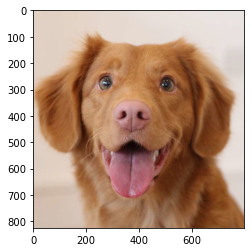

In [7]:
img, label = custom.__getitem__(0)
# permute changing the image channel order from ch-first to ch-last format 
plt.imshow(img.permute(1,2,0)) 

## Preparing data for training with DataLoaders

`Dataset` retrieves our dataset's features and labels one sample at the time. While training a model w typically want to pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's `multiprocessing` to speed upd data retrieval.

`DataLodaer` is an iterable that abstracts this complexity for us in and easy API.

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate trough the DataLoader

We have loaded that dataset into `DataLoader` and can iterate trough the dataset as needed. Each iteration below returns a batch of `train_features` (images) and `train_labels` (containing `batch_size=64` features and labels respectively). Because we specified `shuffle=True`, after we iterate over all batches the data is shuffled (for finger-grained control over the data loading order, take a look at Samplers).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


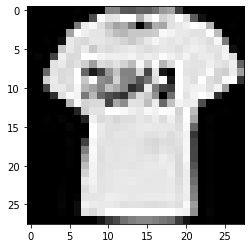

Label: 0


In [9]:
# Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Using DataLoader with our custom dataset



custom_dataset/imgs/cat.jpg
torch.Size([1, 3, 675, 1200])
torch.Size([3, 675, 1200])


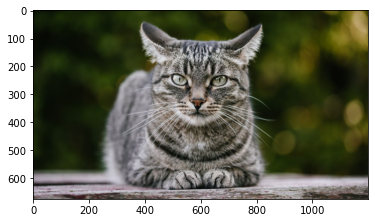

Label: 1


In [10]:
custom_dataloader = DataLoader(custom, batch_size=1, shuffle=True)
train_features, train_labels = next(iter(custom_dataloader))
print(train_features.shape)
print(train_features[0].squeeze().shape)

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")